# Step 1 : テキストの Embedding とデータベースへの保存

> 注意 : この処理は時間がかかります。時間内に終了できない場合は、本 notebook を飛ばして、リポジトリ内のファイル ```embeddings_data_backup.csv``` の名前を ```embeddings_data.csv``` に変更して、Step 2 以降から実施してください。

Azure OpenAI Service の Embedding モデルを使用して、テキストをベクトル化し、データベースに保存します。

- 今回は、Hugging Face に登録されている JaQuAD (日本語版の Wikipedia のデータセット) を使用します。先頭 1000 件のデータのみを使用します。
- 今回は、データベースの代わりに、CSV ファイルに保存します。
- 今回は、OpenAI の Embedding として ```text-embedding-ada-002``` (1536 次元のベクトルを生成) を使用します。

まず、Hugging Face に登録されている日本語 Wikipedia データセット (JaQuAD) から、先頭の 1000 件のデータを取得します。

In [1]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("SkelterLabsInc/JaQuAD")
df_context = pd.DataFrame(
    ds["train"]["context"],
    columns=["text"]
)
df_context = df_context.drop_duplicates()
df = df_context[:1000]
df

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

,text
0,手塚治虫(てづかおさむ、本名:手塚治(読み同じ)、1928年(昭和3年)11月3日-1989...
2,大阪帝国大学附属医学専門部在学中の1946年1月1日に4コマ漫画『マアチャンの日記帳』(『少...
6,1941年、大阪府立北野中学校(現在の大阪府立北野高等学校)に入学した。\n時節柄軍事色が強...
9,終戦後、学生である手塚は戦時中に描き溜めた長編の中から『幽霊男』(『メトロポリス』の原型)と...
10,漫画家としてデビューする前の1945年頃、2代目桂春団治が地方での自主興行を行う際のポスター...
...,...
2806,"アメリカ合衆国統計局によると、ヒューストン市の総面積は1,558.4km2である。そのうち1..."
2809,バイユー・シティの別名が示す通り、ヒューストン市内にはバイユーと呼ばれる小川がいくつも流れて...
2811,ヒューストンの夏の日中の気温は摂氏30度を上回ることが常である。過去の統計の平均では、最高気...
2813,一方、ヒューストンの冬は温暖で、過ごしやすい日が続く。最寒月の1月においても、月平均気温は摂...


Embedding の前に、テキストの標準化 (ノーマライズ) をおこないます。<br>
今回は、各ドキュメントの改行を削除し、日本語の空白を半角の空白にそろえます。

In [2]:
def remove_newlines(serie):
    serie = serie.str.replace("\n", " ", regex=True)
    serie = serie.str.replace("\\n", " ", regex=True)
    serie = serie.str.replace("  ", " ", regex=True)
    serie = serie.str.replace("  ", " ", regex=True)
    return serie

df["text"] = remove_newlines(df.text)
df["text"][0]

/tmp/ipykernel_3552/372861816.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = remove_newlines(df.text)


'手塚治虫(てづかおさむ、本名:手塚治(読み同じ)、1928年(昭和3年)11月3日-1989年(平成元年)2月9日)は、日本の漫画家、アニメーター、アニメ監督である。 戦後日本においてストーリー漫画の第一人者として、漫画表現の開拓者的な存在として活躍した。 兵庫県宝塚市出身(出生は大阪府豊能郡豊中町、現在の豊中市)同市名誉市民である。 大阪帝国大学附属医学専門部を卒業。 医師免許取得のち医学博士(奈良県立医科大学・1961年)。'

いったん、CSV ファイル (```document_data.csv```) に保存します

In [3]:
df.to_csv("document_data.csv")
df.head()

,text
0,手塚治虫(てづかおさむ、本名:手塚治(読み同じ)、1928年(昭和3年)11月3日-1989...
2,大阪帝国大学附属医学専門部在学中の1946年1月1日に4コマ漫画『マアチャンの日記帳』(『少...
6,1941年、大阪府立北野中学校(現在の大阪府立北野高等学校)に入学した。 時節柄軍事色が強ま...
9,終戦後、学生である手塚は戦時中に描き溜めた長編の中から『幽霊男』(『メトロポリス』の原型)と...
10,漫画家としてデビューする前の1945年頃、2代目桂春団治が地方での自主興行を行う際のポスター...


使用されている token 数の統計を表示します。

> Note : この token は、OpenAI ChatGPT で扱うものと同様です。

Matplotlib is building the font cache; this may take a moment.


<Axes: >

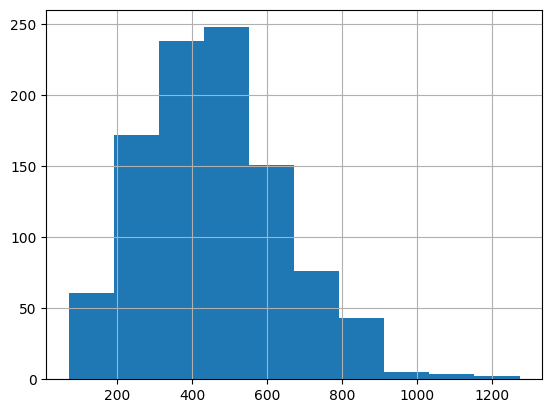

In [4]:
import tiktoken

# Load tokenizer
#tokenizer = tiktoken.get_encoding("gpt2")
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv("document_data.csv", index_col=0)
df.columns = ["text"]

# Tokenize the text and save the number of tokens to a new column
df["n_tokens"] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

Azure OpenAI Service を使って 1000 件のテキストに Embedding を実行し、作成されたベクトル情報を CSV (```embeddings_data.csv```) に保存します。(この処理には、時間がかかります。)<br>
**下記の ```text-embedding-ada-002-deploy``` は、事前に皆さんの環境にあわせて変更してください。**

ここでは、Azure OpenAI Service の rate limit 制限に気をつけながら、```sleep()``` 処理を入れて実行しています。

In [5]:
embedding_model = "text-embedding-ada-002-deploy"

import os
import time
import openai

openai.api_key = os.environ["OPENAI_API_KEY"]
openai.api_base =  os.environ["OPENAI_API_BASE"]
openai.api_type = os.environ["OPENAI_API_TYPE"]
openai.api_version = os.environ["OPENAI_API_VERSION"]

def embed(x):
    time.sleep(0.6)
    return openai.Embedding.create(
        input=x,
        engine=embedding_model)["data"][0]["embedding"]

df["embeddings"] = df.text.apply(embed)
df.to_csv("embeddings_data.csv")
df.head()

,text,n_tokens,embeddings
0,手塚治虫(てづかおさむ、本名:手塚治(読み同じ)、1928年(昭和3年)11月3日-1989...,249,"[-0.011639331467449665, -0.0028115962632000446..."
2,大阪帝国大学附属医学専門部在学中の1946年1月1日に4コマ漫画『マアチャンの日記帳』(『少...,555,"[-0.005988525692373514, -0.020313821732997894,..."
6,1941年、大阪府立北野中学校(現在の大阪府立北野高等学校)に入学した。 時節柄軍事色が強ま...,862,"[-0.0008580254507251084, -0.009806005284190178..."
9,終戦後、学生である手塚は戦時中に描き溜めた長編の中から『幽霊男』(『メトロポリス』の原型)と...,499,"[-0.012157808057963848, -0.006739071570336819,..."
10,漫画家としてデビューする前の1945年頃、2代目桂春団治が地方での自主興行を行う際のポスター...,460,"[-0.00843341276049614, -0.015178769826889038, ..."


今回、作成されたベクトルの次元数は、1536 次元です。

In [6]:
len(df["embeddings"][0])

1536